# HVC-VAC
Halftoning visual cryptography (HVC) based on void-and-cluster dithering (VAC) <br>
We built it entirely from scatch with only numpy. OpenCV and matplotlib is used for reading, showing and saving image only. Also we use Scipy's convolution implementation for speed. <br>
Written in 2020 by Chia-Che, Sa (SaKaTetsu)

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.signal import convolve2d as convolution

In [2]:
class clock():
    def tick(self):
        self.st = time.time()
    
    def tock(self):
        self.et = time.time()
        
    def get_time(self):
        return self.et - self.st
    
timer = clock()

In [3]:
def read_image(path, resize=None):
    if not path: return None
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if resize: img = cv2.resize(img, (resize[1], resize[0]))
    img = img / 255.
    return img

def save_image(path, img):
    if np.max(img) <= 1.0: img = img * 255.
    cv2.imwrite(path, img)

def show_image(img, title=None):
    plt.figure()
    if title: plt.title(title)
    plt.imshow(img, cmap='gray')
    plt.show()

### Load images

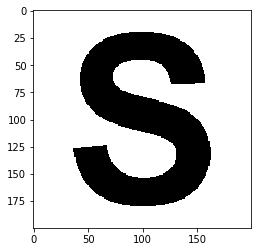

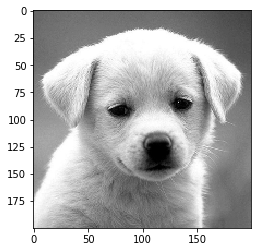

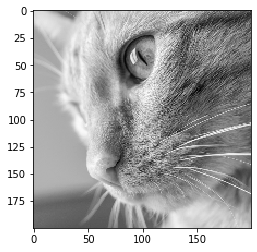

In [4]:
secret_image = read_image('secret_image.jpg', resize=(200, 200))
secret_image[secret_image >= 0.5] = 1.0
secret_image[secret_image < 0.5] = 0.0
show_image(secret_image)
shared_image_1 = read_image('test1.jpg', resize=secret_image.shape)
show_image(shared_image_1)
shared_image_2 = read_image('test2.jpg', resize=secret_image.shape)
show_image(shared_image_2)

### Prepare some functions

In [5]:
def decode_shares(share1, share2):
    # We use XNOR for decoding rather than simple adding
    # We would then have some good properties for our authentication scheme
    decode = np.logical_not(np.logical_xor(share1, share2)).astype(float)
    return decode

### The HVC-VAC algorithm
![](./workflow.jpg)

In [6]:
class HVC_VAC():
    def __init__(self, secret, shape=None, kernel=None, max_iter=100000, verbose=1):
        timer = clock()
        timer.tick()
        self.secret = secret
        self.w_mask = self.secret == 1
        self.b_mask = self.secret == 0
        self.w_size = np.sum(self.w_mask)
        self.b_size = np.sum(self.b_mask)
        self.shape = self.secret.shape
        self.size = np.prod(self.shape)
        self.kernel = self._get_kernel(kernel)
        self.kernel_size = self.kernel.shape
        self.max_iter = max_iter
        self.verbose = verbose
        timer.tock()
        if self.verbose: print("INFO: HVC-VAC initialization done, time: %.5fs" % timer.get_time())

    def _flip01(self, arr):
        return np.logical_not(arr)

    def _gaussian_kernel(self, kernel_size=9, sigma=1.5, mean=0.0):
        ax = np.linspace(-(kernel_size - 1) / 2., (kernel_size - 1) / 2., kernel_size)
        xx, yy = np.meshgrid(ax, ax)
        kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sigma))
        return kernel / np.sum(kernel)

    def _get_kernel(self, kernel):
        if kernel is not None: return kernel
        return self._gaussian_kernel(9, sigma=1.5, mean=0.0)

    def _get_score(self, pattern, target):
        if target == 'void': pattern = self._flip01(pattern)
        score = convolution(pattern, self.kernel, mode='same', boundary='wrap')
        score[pattern == 0.0] = 0.0
        return score

    def _find_void_cluster(self, target, index, region=None):
        if target == 'cluster': 
            scores = self.cluster_scores[index]
        elif target == 'void':
            scores = self.void_scores[index]
            
        if region == 'W':
            scores[self.b_mask] = 0.0
        elif region == 'B':
            scores[self.w_mask] = 0.0
            
        max_index = np.argmax(scores)
                
        return np.unravel_index(max_index, self.shape)
    
    def run_step_0(self):
        timer = clock()
        timer.tick()
        flat_mask = np.arange(np.prod(self.secret.shape))
        
        # Select white region
        W_1 = np.random.choice(flat_mask, size=self.w_size//2, replace=False, p=self.w_mask.flatten()/np.sum(self.w_mask))
        W_0_p = self.w_mask.flatten()
        W_0_p[W_1] = 0.0
        W_0 = np.random.choice(flat_mask, size=self.w_size//2, replace=False, p=W_0_p / np.sum(W_0_p))
        
        # Select black region
        B_1 = np.random.choice(flat_mask, size=self.b_size//2, replace=False, p=self.b_mask.flatten()/np.sum(self.b_mask))
        B_0_p = self.b_mask.flatten()
        B_0_p[B_1] = 0.0
        B_0 = np.random.choice(flat_mask, size=self.b_size//2, replace=False, p=B_0_p / np.sum(B_0_p))
        
        # Get Rp1 & RP2
        RP1 = np.zeros(self.secret.flatten().shape)
        RP2 = np.zeros(self.secret.flatten().shape)
        # Give same      pixel value on RP1 & RP2 in white region so we would have pixel value 1 after XNOR
        # Give different pixel value on RP1 & RP2 in white region so we would have pixel value 0 after XNOR
        RP1[W_0] = 0
        RP2[W_0] = 0
        RP1[W_1] = 1
        RP2[W_1] = 1
        RP1[B_0] = 0
        RP2[B_0] = 1
        RP1[B_1] = 1
        RP2[B_1] = 0
        self.RPs = [np.reshape(RP1, self.secret.shape), np.reshape(RP2, self.secret.shape)]
        
        cluster_score_1 = self._get_score(self.RPs[0], 'cluster')
        cluster_score_2 = self._get_score(self.RPs[1], 'cluster')
        self.cluster_scores = [cluster_score_1, cluster_score_2]
        void_score_1 = self._get_score(self.RPs[0], 'void')
        void_score_2 = self._get_score(self.RPs[1], 'void')
        self.void_scores = [void_score_1, void_score_2]
        
        timer.tock()
        if self.verbose: print("INFO: Step 0 done, time: %.5fs" % timer.get_time())      

    def _update_void_cluster_score(self, prototype, pos, index, target=None):
        x, y = pos
        kx_, ky_ = self.kernel_size
        kx = kx_ // 2
        ky = ky_ // 2
        pad_prototype = np.pad(prototype, (2*kx, 2*ky), mode='wrap')
        px_min, px_max = x, x + 4*kx + 1
        py_min, py_max = y, y + 4*ky + 1
        patch = pad_prototype[px_min:px_max, py_min:py_max]
        offset_x, offset_y = (x - kx) % self.shape[0], (y - ky) % self.shape[1]
        
        # Cluster score update
        if target is None or target == 'cluster':
            cluster_patch = patch
            cluster_patch_score = convolution(cluster_patch, self.kernel, mode='valid')
            cluster_patch_score[cluster_patch[kx:-kx, ky:-ky] == 0.0] = 0.0
            # First roll the score matrix to move the update patch to (0, 0)
            # purpose for this is to avoid overflow wrap around problems
            cluster_shift_score = np.roll(np.roll(self.cluster_scores[index], -offset_x, axis=0), -offset_y, axis=1)
            cluster_shift_score[:kx_, :ky_] = cluster_patch_score
            self.cluster_scores[index] = np.roll(np.roll(cluster_shift_score, offset_x, axis=0), offset_y, axis=1)
        
        # Void score update
        if target is None or target == 'void':
            void_patch = self._flip01(patch)
            void_patch_score = convolution(void_patch, self.kernel, mode='valid')
            void_patch_score[void_patch[kx:-kx, ky:-ky] == 0.0] = 0.0
            # First roll the score matrix to move the update patch to (0, 0)
            # purpose for this is to avoid overflow wrap around problems
            void_shift_score = np.roll(np.roll(self.void_scores[index], -offset_x, axis=0), -offset_y, axis=1)
            void_shift_score[:kx_, :ky_] = void_patch_score
            self.void_scores[index] = np.roll(np.roll(void_shift_score, offset_x, axis=0), offset_y, axis=1)
            
    def run_step_1(self):
        timer = clock()
        SPs = [self.RPs[0].copy(), self.RPs[1].copy()]
        timer.tick()
        
        for i in range(self.max_iter):
            # Select RP to run on
            index = np.random.randint(2)
            region = None
            
            # Find tightest cluster on selected RP
            cluster_pos = self._find_void_cluster('cluster', index=index, region=region)
            SPs[index][cluster_pos] = 0.0
            self._update_void_cluster_score(SPs[index], cluster_pos, index=index)
            if self.secret[cluster_pos] == 1.0: region = 'W'
            else: region = 'B'
            
            # Find largest void on selected RP
            void_pos = self._find_void_cluster('void', index=index, region=region)
            SPs[index][void_pos] = 1.0
            self._update_void_cluster_score(SPs[index], void_pos, index=index)
            
            # Repeat on the other RP
            index = int(not index)
            if region == 'W':
                SPs[index][cluster_pos] = 0.0
                self._update_void_cluster_score(SPs[index], cluster_pos, index=index)
                SPs[index][void_pos] = 1.0
                self._update_void_cluster_score(SPs[index], void_pos, index=index)
            else:
                SPs[index][cluster_pos] = 1.0
                self._update_void_cluster_score(SPs[index], cluster_pos, index=index)
                SPs[index][void_pos] = 0.0
                self._update_void_cluster_score(SPs[index], void_pos, index=index)
            
            # Check termination
            if cluster_pos == void_pos: break
        self.SPs = SPs
                
        timer.tock()
        if self.verbose: print("INFO: Step 1 done, time: %.5fs" % timer.get_time())
    
    def run_step_2(self):
        timer.tick()
        dither_matrix_1 = self.vac_operation_2(0)
        dither_matrix_2 = self.vac_operation_2(1)
        self.TAs = [dither_matrix_1, dither_matrix_2]
        timer.tock()
        if self.verbose: print("INFO: Step2 done, time: %.5fs" % timer.get_time())

    def vac_operation_2(self, index):
        # dither matrix generation
        dither_matrix = np.zeros(self.shape, dtype=float)
        ones = int(np.sum(self.SPs[index]))
        
        # Phase I
        pattern = self.SPs[index].copy()
        self.cluster_score = self._get_score(pattern, target='cluster')
        for rank in reversed(range(ones)):
            cluster_pos = self._find_void_cluster(target='cluster', index=index)
            pattern[cluster_pos] = 0
            self._update_void_cluster_score(pattern, cluster_pos, index=index, target='cluster')
            dither_matrix[cluster_pos] = rank
            
        # Phase II
        pattern = self.SPs[index].copy()
        self.void_score = self._get_score(pattern, 'void')
        for rank in range(ones, self.size):
            void_pos = self._find_void_cluster(target='void', index=index)
            pattern[void_pos] = 1
            self._update_void_cluster_score(pattern, void_pos, index=index, target='void')
            dither_matrix[void_pos] = rank
            
        # Normalize
        dither_matrix_norm = dither_matrix / self.size
        
        return dither_matrix_norm

    def run(self):
        self.run_step_0()
        self.run_step_1()
        self.run_step_2()
        
    def halftone(self, image, index, resample_range=(0.125, 0.875)):
        image = cv2.resize(image, (self.shape[1], self.shape[0]))
        image = image * np.abs(np.subtract(resample_range[1], resample_range[0])) + resample_range[0]
        halftone_img = np.zeros(image.shape)
        halftone_img[image > self.TAs[index]] = 1.0
        return halftone_img

INFO: HVC-VAC initialization done, time: 0.00000s
INFO: Step 0 done, time: 0.07580s


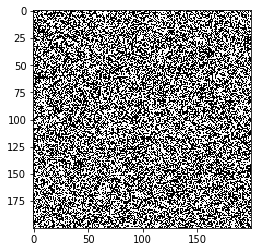

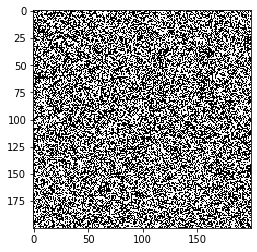

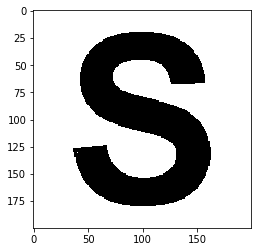

In [7]:
# Step 0: Binary Random Pattern Generation
hvc_vac = HVC_VAC(secret_image)
hvc_vac.run_step_0()
show_image(hvc_vac.RPs[0])
show_image(hvc_vac.RPs[1])
show_image(decode_shares(hvc_vac.RPs[0], hvc_vac.RPs[1]))
# save_image('RP1.png', hvc_vac.RPs[0])
# save_image('RP2.png', hvc_vac.RPs[1])
# save_image('decodeRP.png', decode_shares(hvc_vac.RPs[0], hvc_vac.RPs[1]))

INFO: Step 1 done, time: 14.17513s


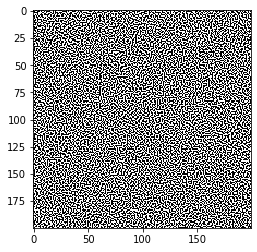

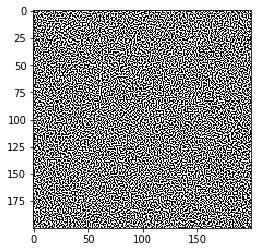

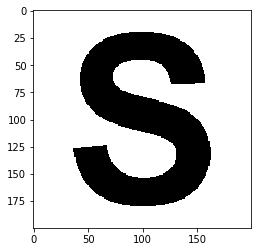

In [8]:
# Step 1: Binary Seed Pattern Generation
hvc_vac.run_step_1()
show_image(hvc_vac.SPs[0])
show_image(hvc_vac.SPs[1])
show_image(decode_shares(hvc_vac.SPs[0], hvc_vac.SPs[1]))
# save_image('SP1.png', hvc_vac.SPs[0])
# save_image('SP2.png', hvc_vac.SPs[1])
# save_image('decodeSP.png', decode_shares(hvc_vac.SPs[0], hvc_vac.SPs[1]))

INFO: Step2 done, time: 31.15771s


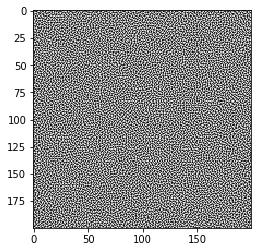

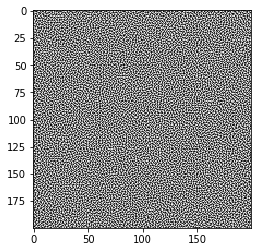

In [9]:
# Step 2: Threshold Array Generation
hvc_vac.run_step_2()
# save_image('TA1.png', hvc_vac.TAs[0])
# save_image('TA2.png', hvc_vac.TAs[1])
show_image(hvc_vac.TAs[0])
show_image(hvc_vac.TAs[1])

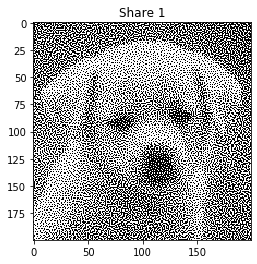

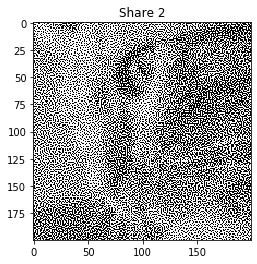

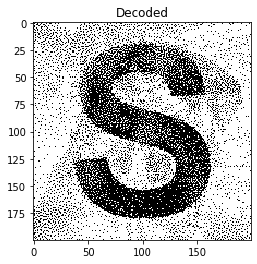

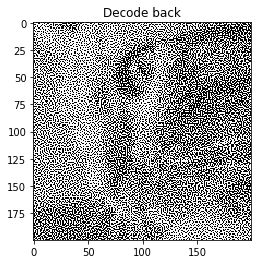

In [10]:
# Try Encode Image and Decode it
gray_image = np.ones(secret_image.shape) * 0.5
ht_shared_image_1 = hvc_vac.halftone(shared_image_1, index=0, resample_range=(0.2, 0.8))
ht_shared_image_2 = hvc_vac.halftone(shared_image_2, index=1, resample_range=(0.2, 0.8))
decoded = decode_shares(ht_shared_image_1, ht_shared_image_2)
show_image(ht_shared_image_1, 'Share 1')
show_image(ht_shared_image_2, 'Share 2')
show_image(decoded, 'Decoded')
show_image(decode_shares(decoded, ht_shared_image_1), 'Decode back')
# save_image("share1.png", ht_shared_image_1)
# save_image("share2.png", ht_shared_image_2)
# save_image('decoded.png', decoded)

### Authentication Scheme
We propose an authentication scheme besed on the HVC-VAC algorithm

In [11]:
# coding=UTF-8
from PIL import Image, ImageDraw, ImageFont
class text2image():
    def __init__(self, size):
        self.size = size
        # This font is for mandarin character generation
        self.font = ImageFont.truetype('./NotoSansCJK-Black.ttc', 150)
        
    def get(self, text, foreground=0.0, background=1.0, position=(30, -10)):
        img = np.ones(self.size) * background
        img = Image.fromarray(img)
        draw = ImageDraw.Draw(img)
        draw.text(position, text, font=self.font, fill=foreground)
        img = np.array(img)
        return img

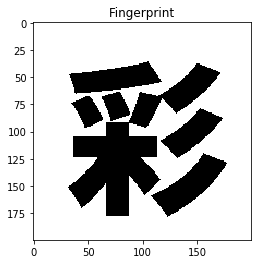

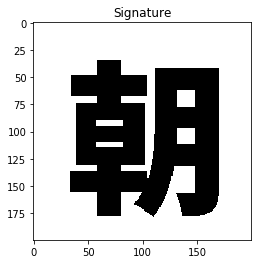

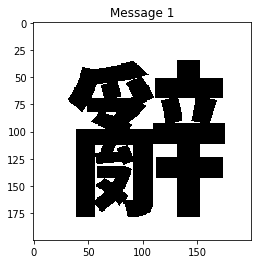

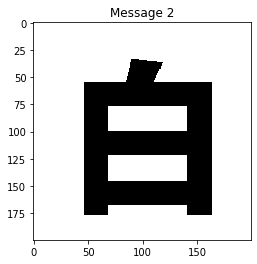

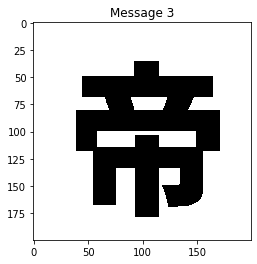

In [12]:
text_generator = text2image(size=(200, 200))
img_fingerprint = text_generator.get('彩')
show_image(img_fingerprint, 'Fingerprint')
img_signature = text_generator.get('朝')
show_image(img_signature, 'Signature')
img_message_1 = text_generator.get('辭')
show_image(img_message_1, 'Message 1')
img_message_2 = text_generator.get('白')
show_image(img_message_2, 'Message 2')
img_message_3 = text_generator.get('帝')
show_image(img_message_3, 'Message 3')

In [13]:
# Encode the fingerprint with HVC-VAC algorithm
hvc_vac = HVC_VAC(img_fingerprint)
hvc_vac.run()

INFO: HVC-VAC initialization done, time: 0.00099s
INFO: Step 0 done, time: 0.07982s
INFO: Step 1 done, time: 17.40545s
INFO: Step2 done, time: 30.55032s


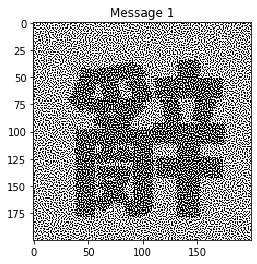

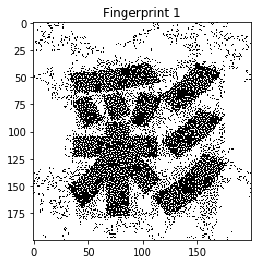

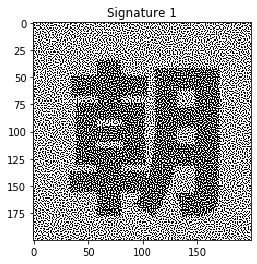

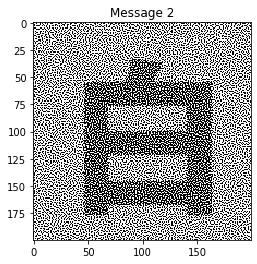

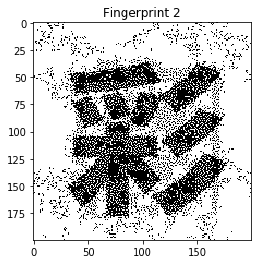

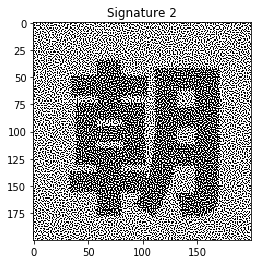

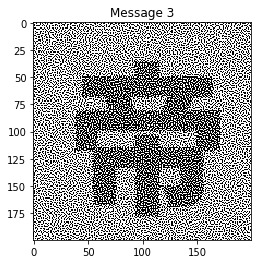

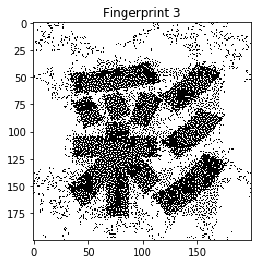

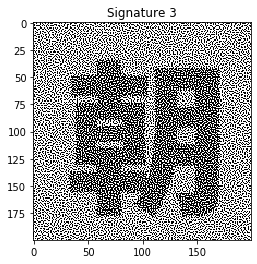

In [14]:
# We send the messages and fingerprints, and the user could decode the signatures with XNOR operation
# We use resample range (0.35, 0.65) since it has good visual results, could be modified to other value range
ht_signature = hvc_vac.halftone(img_signature, 0, resample_range=(0.35, 0.65))
ht_message_1 = hvc_vac.halftone(img_message_1, 1, resample_range=(0.35, 0.65))
show_image(ht_message_1, 'Message 1')
fingerprint_message_1 = decode_shares(ht_signature, ht_message_1)
show_image(fingerprint_message_1, 'Fingerprint 1')
signature_message_1 = decode_shares(fingerprint_message_1, ht_message_1)
show_image(signature_message_1, 'Signature 1')

print("===============================================")

ht_message_2 = hvc_vac.halftone(img_message_2, 1, resample_range=(0.35, 0.65))
show_image(ht_message_2, 'Message 2')
fingerprint_message_2 = decode_shares(ht_signature, ht_message_2)
show_image(fingerprint_message_2, 'Fingerprint 2')
signature_message_2 = decode_shares(fingerprint_message_2, ht_message_2)
show_image(signature_message_2, 'Signature 2')

print("===============================================")

ht_message_3 = hvc_vac.halftone(img_message_3, 1, resample_range=(0.35, 0.65))
show_image(ht_message_3, 'Message 3')
fingerprint_message_3 = decode_shares(ht_signature, ht_message_3)
show_image(fingerprint_message_3, 'Fingerprint 3')
signature_message_3 = decode_shares(fingerprint_message_3, ht_message_3)
show_image(signature_message_3, 'Signature 3')

In [15]:
# Check the signatures are identical
# If they aren't, then the message or fingerprint might be modified
print("Same pixel value ratio of signature 1 & 2: %.2f %%" % (np.sum(signature_message_1 == signature_message_2) / np.prod(img_fingerprint.shape) * 100))
print("Same pixel value ratio of signature 2 & 3: %.2f %%" % (np.sum(signature_message_2 == signature_message_3) / np.prod(img_fingerprint.shape) * 100))
print("Same pixel value ratio of signature 1 & 3: %.2f %%" % (np.sum(signature_message_1 == signature_message_3) / np.prod(img_fingerprint.shape) * 100))
print()
# Fingerprints should not be identical but should be similar visually
print("Same pixel value ratio of fingerprint 1 & 2: %.2f %%" % (np.sum(fingerprint_message_1 == fingerprint_message_2) / np.prod(img_fingerprint.shape) * 100))
print("Same pixel value ratio of fingerprint 2 & 3: %.2f %%" % (np.sum(fingerprint_message_2 == fingerprint_message_3) / np.prod(img_fingerprint.shape) * 100))
print("Same pixel value ratio of fingerprint 1 & 3: %.2f %%" % (np.sum(fingerprint_message_1 == fingerprint_message_3) / np.prod(img_fingerprint.shape) * 100))

Same pixel value ratio of signature 1 & 2: 100.00 %
Same pixel value ratio of signature 2 & 3: 100.00 %
Same pixel value ratio of signature 1 & 3: 100.00 %

Same pixel value ratio of fingerprint 1 & 2: 93.66 %
Same pixel value ratio of fingerprint 2 & 3: 94.03 %
Same pixel value ratio of fingerprint 1 & 3: 93.84 %
